In [1]:
import numpy as np
import pandas as pd

from pydantic import BaseModel, PydanticUserError
from scipy.stats import cauchy
import matplotlib.pyplot as plt

In [2]:
class LiquidityProfile(BaseModel):
    """
    Generic model for concentrated liquidity global liquidity density function.
    
    Should require int_{-\infty}^{\infty} l(t)dt = C, where C is a global constant
    when no LPs add or remove funds from pool.

    Assumes continuous liquidity profile and input ticks are in "natural log" form
    such that price p = e ** (t), where t is the tick.
    """
    c: float

    def at(self, t: int) -> int:
        """
        `at` takes a tick value as input and returns the concentrated liquidity value
        in the pool.
        """
        raise PydanticUserError("Function not implemented.", code=None)

    def slip_y(self, t: int) -> int:
        """
        Tick slippage with respect to an infinitesimal amount of y.
        """
        return (2 / self.at(t)) * np.exp(-t/2)

    def slip_x(self, t: int) -> int:
        """
        Tick slippage with respect to an infinitesimal amount of x.
        """
        return - (2 / self.at(t)) * np.exp(t/2)

In [3]:
class CauchyLiquidityProfile(LiquidityProfile):
    """
    Cauchy distribution liquidity profile, with shape described by one scale parameter: gamma.

    l(t) = (c / (pi * gamma)) * (1 / (1 + (t / gamma) ** 2))
    """
    gamma: float

    def at(self, t: int) -> int:
        return self.c * cauchy.pdf(t, 0, self.gamma)

In [4]:
def from_bps_tick(tb: int) -> int:
    """
    Converts tick in bps form i.e. p = 1.0001 ** (tb)
    to tick in natural log form: p = e ** (t).
    """
    return np.log(1.0001) * tb

In [5]:
C = 10.0  # total liquidity parameter
GAMMA = 0.1  # scale parameter
MAX_TICK = 887272

In [6]:
clp = CauchyLiquidityProfile(c=C, gamma=GAMMA)

In [7]:
# should be c / (pi * gamma)
clp.at(0) == C / (np.pi * GAMMA)

True

In [8]:
# plot liquidity profile over ticks
bps_ticks = np.arange(start=-MAX_TICK, stop=MAX_TICK, step=10)
log_ticks = from_bps_tick(bps_ticks)
liquidities = clp.at(log_ticks)

In [9]:
df = pd.DataFrame(data={'bps_ticks': bps_ticks, 'log_ticks': log_ticks, f'l(t) [c={C}, g={GAMMA}]': liquidities})
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]"
0,-887272,-88.722764,0.00004
1,-887262,-88.721764,0.00004
2,-887252,-88.720764,0.00004
3,-887242,-88.719764,0.00004
4,-887232,-88.718764,0.00004
...,...,...,...
177450,887228,88.718364,0.00004
177451,887238,88.719364,0.00004
177452,887248,88.720364,0.00004
177453,887258,88.721364,0.00004


<Axes: xlabel='bps_ticks'>

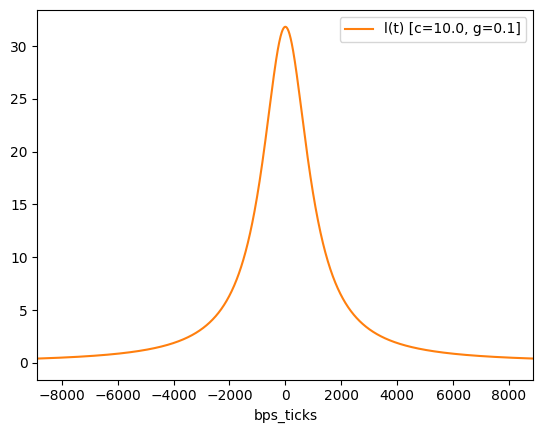

In [10]:
# plot +/- 60% 
df.plot(x='bps_ticks', y=f'l(t) [c={C}, g={GAMMA}]', xlim=(-MAX_TICK // 100, MAX_TICK // 100), color='C1')

In [11]:
# generate for more gammas
gammas = np.array([0.05, 0.1, 0.2, 0.4])

In [12]:
for g in gammas:
    df[f'l(t) [c={C}, g={g}]'] = CauchyLiquidityProfile(c=C, gamma=g).at(log_ticks)

In [13]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.4]"
0,-887272,-88.722764,0.00004,0.00002,0.000081,0.000162
1,-887262,-88.721764,0.00004,0.00002,0.000081,0.000162
2,-887252,-88.720764,0.00004,0.00002,0.000081,0.000162
3,-887242,-88.719764,0.00004,0.00002,0.000081,0.000162
4,-887232,-88.718764,0.00004,0.00002,0.000081,0.000162
...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.00002,0.000081,0.000162
177451,887238,88.719364,0.00004,0.00002,0.000081,0.000162
177452,887248,88.720364,0.00004,0.00002,0.000081,0.000162
177453,887258,88.721364,0.00004,0.00002,0.000081,0.000162


<Axes: xlabel='bps_ticks'>

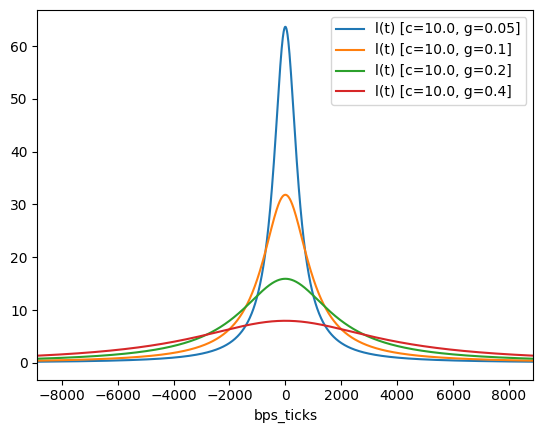

In [14]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={g}]' for g in gammas], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

<Axes: xlabel='bps_ticks'>

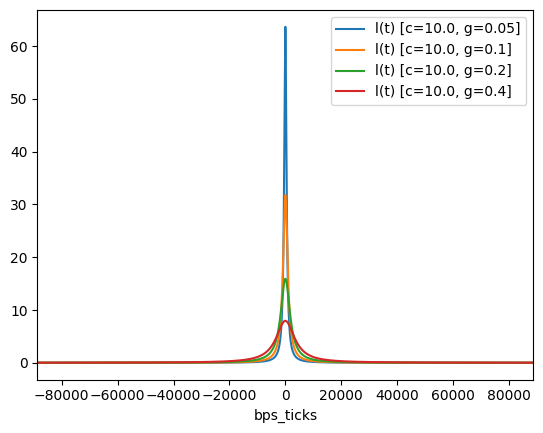

In [15]:
df.plot(x='bps_ticks', y=[f'l(t) [c={C}, g={g}]' for g in gammas], xlim=(-MAX_TICK // 10, MAX_TICK // 10))

In [16]:
# generate for more global liquidity constant values
cs = np.array([5.0, 10.0, 20.0, 40.0])

In [17]:
for c in cs:
    df[f'l(t) [c={c}, g={GAMMA}]'] = CauchyLiquidityProfile(c=c, gamma=GAMMA).at(log_ticks)

In [18]:
df

,bps_ticks,log_ticks,"l(t) [c=10.0, g=0.1]","l(t) [c=10.0, g=0.05]","l(t) [c=10.0, g=0.2]","l(t) [c=10.0, g=0.4]","l(t) [c=5.0, g=0.1]","l(t) [c=20.0, g=0.1]","l(t) [c=40.0, g=0.1]"
0,-887272,-88.722764,0.00004,0.00002,0.000081,0.000162,0.00002,0.000081,0.000162
1,-887262,-88.721764,0.00004,0.00002,0.000081,0.000162,0.00002,0.000081,0.000162
2,-887252,-88.720764,0.00004,0.00002,0.000081,0.000162,0.00002,0.000081,0.000162
3,-887242,-88.719764,0.00004,0.00002,0.000081,0.000162,0.00002,0.000081,0.000162
4,-887232,-88.718764,0.00004,0.00002,0.000081,0.000162,0.00002,0.000081,0.000162
...,...,...,...,...,...,...,...,...,...
177450,887228,88.718364,0.00004,0.00002,0.000081,0.000162,0.00002,0.000081,0.000162
177451,887238,88.719364,0.00004,0.00002,0.000081,0.000162,0.00002,0.000081,0.000162
177452,887248,88.720364,0.00004,0.00002,0.000081,0.000162,0.00002,0.000081,0.000162
177453,887258,88.721364,0.00004,0.00002,0.000081,0.000162,0.00002,0.000081,0.000162


<Axes: xlabel='bps_ticks'>

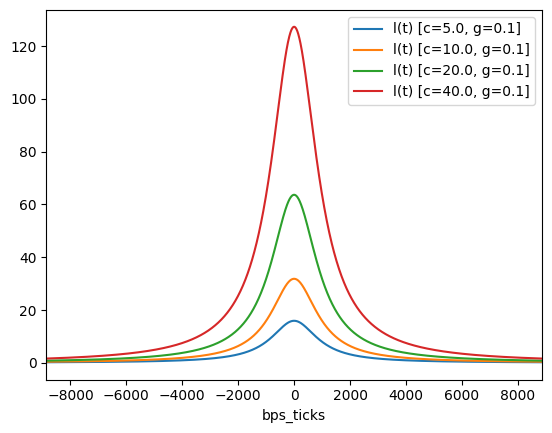

In [19]:
df.plot(x='bps_ticks', y=[f'l(t) [c={c}, g={GAMMA}]' for c in cs], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [20]:
# examine slippage for base Cauchy case of C, GAMMA
df[f'dt/dy [c={C}, g={GAMMA}]'] = clp.slip_y(log_ticks)
df[f'dt/dx [c={C}, g={GAMMA}]'] = clp.slip_x(log_ticks)

<Axes: xlabel='bps_ticks'>

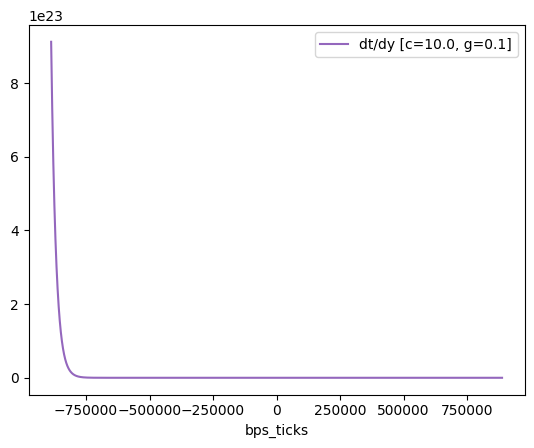

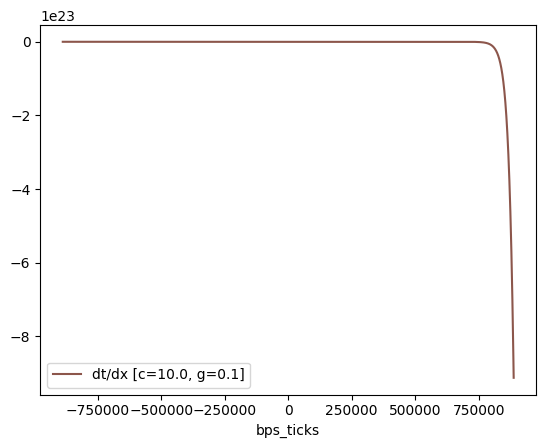

In [21]:
# plot y and x slippage across all ticks
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4')
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5')

In [22]:
df[f'dt/dy [c={C}, g={GAMMA}]']

0         9.123342e+23
1         9.118576e+23
2         9.113813e+23
3         9.109052e+23
4         9.104293e+23
              ...     
177450    2.686949e-15
177451    2.685667e-15
177452    2.684385e-15
177453    2.683104e-15
177454    2.681823e-15
Name: dt/dy [c=10.0, g=0.1], Length: 177455, dtype: float64

In [23]:
# if pool is 10 bps away from p=1, and swap in 10% of liquidity in y
# should expect tick to increase by ~6% to 10.63 bps away
(0.1 * clp.c) * clp.slip_y(from_bps_tick(10))

0.06280672598454913

<Axes: xlabel='bps_ticks'>

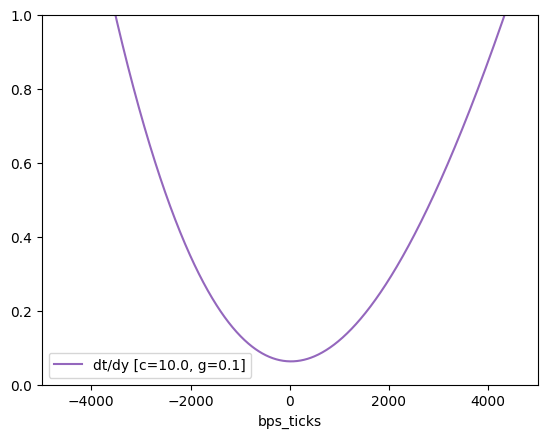

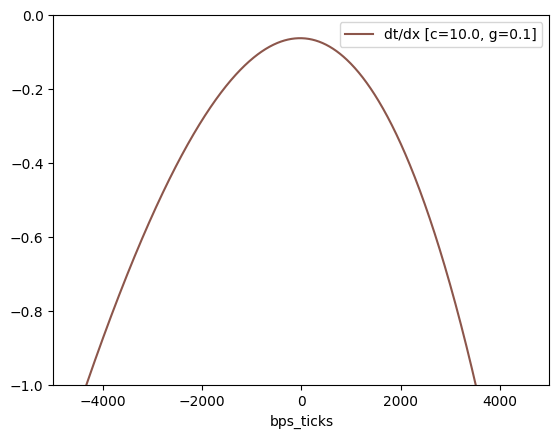

In [24]:
# plot y and x slippage across near tick=0 to +/-50%
# slippage accelerates as move toward price extremes, but bottoms as approach tick=0
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4', xlim=(-5000, 5000), ylim=(0, 1.0))
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5', xlim=(-5000, 5000), ylim=(-1.0, 0))

<Axes: xlabel='bps_ticks'>

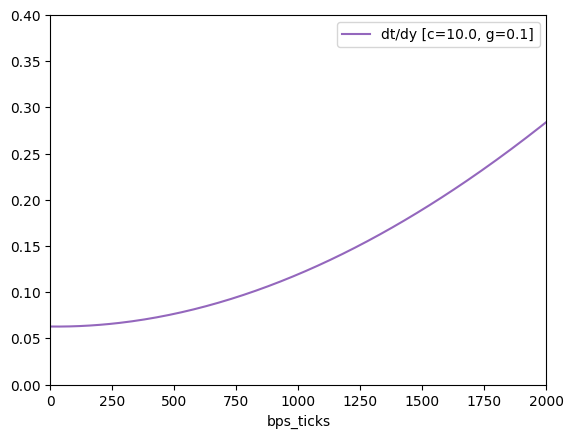

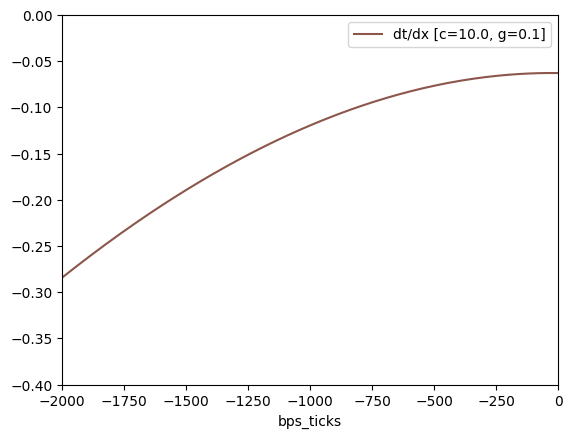

In [25]:
# plot y and x slippage from tick=0 to +/-20%
df.plot(x='bps_ticks', y=f'dt/dy [c={C}, g={GAMMA}]', color='C4', xlim=(0, 2000), ylim=(0, 0.4))
df.plot(x='bps_ticks', y=f'dt/dx [c={C}, g={GAMMA}]', color='C5', xlim=(-2000, 0), ylim=(-0.4, 0))